In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

REFERENCE_LLM = "qwen1.5-32B-Chat"

# Load data

In [17]:
from datasets import load_dataset

dataset = load_dataset("llm-council/emotional_application", "response_judging")
df = dataset["council"].to_pandas()

In [18]:
# Use 10% of the data for faster simulations.
df = df[df["emobench_id"].isin(range(100, 110))]

In [19]:
df

,emobench_id,llm_judge,judging_response_string,first_completion_by,second_completion_by,pairwise_choice
0,100,command-r-plus,Explanation: Both responses demonstrate empath...,qwen1.5-32B-Chat,gpt-4o-2024-05-13,B>A
1,102,command-r-plus,Explanation: Both responses exhibit authentici...,claude-3-sonnet,qwen1.5-32B-Chat,B>A
2,100,command-r-plus,Both responses demonstrate empathy and a clear...,llama-3-70b-chat,qwen1.5-32B-Chat,A>B
3,100,command-r-plus,Both responses demonstrate empathy and offer a...,qwen1.5-32B-Chat,command-r,A>B
4,102,command-r-plus,Explanation: Both responses exhibit authentici...,qwen1.5-32B-Chat,gemini-1.0-pro,B>A
...,...,...,...,...,...,...
36511,109,gpt-4-turbo-2024-04-09,Both responses provided to the dilemma offer t...,qwen1.5-32B-Chat,mistral-medium,A>B
36526,109,gpt-4-turbo-2024-04-09,When comparing the two responses regarding the...,qwen1.5-32B-Chat,llama-3-70b-chat,A>B
36533,109,gpt-4-turbo-2024-04-09,Both responses approach the situation with emp...,qwen1.5-32B-Chat,dbrx-instruct,A>B
36537,109,gpt-4-turbo-2024-04-09,Both responses exhibit empathy and understandi...,gpt-4o-2024-05-13,qwen1.5-32B-Chat,B>A


# Library functions

In [21]:
import itertools
import random
from itertools import combinations

council_members = df["llm_judge"].unique()


def calculate_non_overlapping_percentage(
    df, model_column_name="model", lower_column_name="lower", upper_column_name="upper"
):
    # Extract the model names and intervals
    models = df[model_column_name]
    intervals = df[[lower_column_name, upper_column_name]]

    # Calculate all possible pairs of models
    total_pairs = 0
    non_overlapping_pairs = 0

    for (model1, interval1), (model2, interval2) in combinations(
        zip(models, intervals.itertuples(index=False, name=None)), 2
    ):
        total_pairs += 1
        lower1, upper1 = interval1
        lower2, upper2 = interval2

        # Check if intervals do not overlap
        if upper1 < lower2 or upper2 < lower1:
            non_overlapping_pairs += 1

    # Calculate the percentage of non-overlapping pairs
    if total_pairs > 0:
        percentage = (non_overlapping_pairs / total_pairs) * 100
    else:
        percentage = 0  # In case there are not enough models to form a pair

    return percentage



def get_win_rate_column(df, column, baseline):
    to_dict = df[["model", column]].set_index("model").to_dict()[column]
    win_rate_table = predict_win_rate(to_dict)
    return win_rate_table[baseline].fillna(0.5).apply(lambda x: round(x * 100, 2))


def get_win_rate(bootstrap_online_elo, reference_llm_completer):
    stats = pd.DataFrame()
    stats["results"] = None
    stats["results"] = stats["results"].astype("object")

    for i, model in enumerate(bootstrap_online_elo.index):
        stats.at[i, "model"] = model
        stats.at[i, "score"] = bootstrap_online_elo[model]

    return get_win_rate_column(stats, "score", reference_llm_completer)


def predict_win_rate(elo_ratings, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(elo_ratings.keys()))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((elo_ratings[b] - elo_ratings[a]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

def get_battles_from_judgment(df, WEIGHT=3):
    # Modified from https://github.com/lm-sys/arena-hard-auto/blob/main/show_result.py#L112C1-L176C30
    battles = []
    for _, row in df.iterrows():
        output = {
            "question_id": row["emobench_id"],
            "model_a": row["first_completion_by"],
            "model_b": row["second_completion_by"],
        }

        weight = 1
        if row["pairwise_choice"] == "A=B":
            output["winner"] = "tie"
        elif row["pairwise_choice"] == "A>B":
            output["winner"] = "model_a"
        elif row["pairwise_choice"] == "A>>B":
            output["winner"] = "model_a"
            weight = WEIGHT
        elif row["pairwise_choice"] == "B>A":
            output["winner"] = "model_b"
        elif row["pairwise_choice"] == "B>>A":
            output["winner"] = "model_b"
            weight = WEIGHT
        else:
            print("Unknown pairwise_choice: " + row["pairwise_choice"])

        for i in range(weight):
            battles.append(output)

    return pd.DataFrame(battles)


def compute_mle_elo(df, reference_llm_completer, SCALE=400, BASE=10, INIT_RATING=1000):
    df = get_battles_from_judgment(df)

    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "model_a"] = 1.0

    # one tie => one A win + one B win
    # Counts 1 tie as 1 A win and 1 B win, which is why we duplicate the battles.
    tie_idx = df["winner"] == "tie"
    tie_idx[len(tie_idx) // 2 :] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-8)
    lr.fit(X, Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as reference_llm_completer = 1000
    if reference_llm_completer in models.index:
        elo_scores += 1000 - elo_scores[models[reference_llm_completer]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)


def sample_combinations(items, choose, instances):
    # Generate all possible combinations of the specified size
    all_combinations = list(itertools.combinations(items, choose))
    return random.choices(all_combinations, k=instances)


def filter_ratings_with_self_grading(df):
    # Without self-grading.
    df_filtered = df[df["llm_judge"] != df["first_completion_by"]]
    df_filtered = df_filtered[
        df_filtered["llm_judge"] != df_filtered["second_completion_by"]
    ]
    return df_filtered


def filter_ratings_by_allowlist(df, llm_judge_allowlist):
    return df[df["llm_judge"].isin(llm_judge_allowlist)]


def get_adversarial_votes(df, num_adversarial_judges, method):
    all_dfs = [
        get_adversarial_judge_ratings(df, method) for i in range(num_adversarial_judges)
    ]
    return pd.concat(all_dfs)


def get_adversarial_judge_ratings(df, method):
    # Extract unique combinations of 'id', 'first_completion_by', 'second_completion_by'
    adversarial_judge_df = df[
        ["emobench_id", "first_completion_by", "second_completion_by"]
    ].drop_duplicates()

    # Assign fixed values
    adversarial_judge_df["llm_judge"] = "adversarial"
    adversarial_judge_df["metadata"] = None

    # Assign random pairwise choices.
    adversarial_judge_df["pairwise_choice"] = np.random.choice(
        ["A>B", "B>A", "A>>B", "B>>A"], size=len(adversarial_judge_df)
    )
    return adversarial_judge_df


def get_simulated_leaderboard_with_adversarial_judges(
    df,
    council_members,
    jury_size,
    num_samples,
    num_adversarial_judges,
    num_adversarial_judges_frac,
    adversarial_method,
    simulation_normalized_number_judges,
    reference_llm_completer,
):
    win_rate_dict = defaultdict(list)
    rank_dict = defaultdict(list)
    elo_dict = defaultdict(list)
    sampled_jury_compositions = sample_combinations(
        council_members, jury_size, num_samples
    )

    council_win_rate_dict = defaultdict(list)
    council_rank_dict = defaultdict(list)
    council_elo_dict = defaultdict(list)

    # Determine the number of adversarial judges.
    num_real_judges = len(sampled_jury_compositions[0])
    if num_adversarial_judges_frac:
        # 1, 0.5 -> 2, 5, 0.5 -> 7
        num_judges_including_adversaries = int(
            num_real_judges / num_adversarial_judges_frac
        )
        num_adversarial_judges = num_judges_including_adversaries - num_real_judges
    elif num_adversarial_judges:
        num_judges_including_adversaries = num_real_judges + num_adversarial_judges
    else:
        num_judges_including_adversaries = num_real_judges
        num_adversarial_judges = 0
    print(f"- Number of judges: {num_real_judges}")
    print(f"- Number of adversarial judges: {num_adversarial_judges}")
    print(
        f"- Number of judges including adversaries: {num_judges_including_adversaries}"
    )

    for sampled_jury_composition in sampled_jury_compositions:
        filtered_df = filter_ratings_by_allowlist(df, sampled_jury_composition)

        # Add adversarial judges, if applicable.
        if num_adversarial_judges:
            adversarial_df = get_adversarial_votes(
                filtered_df, num_adversarial_judges, adversarial_method
            )
            filtered_df = pd.concat([adversarial_df, filtered_df])

        # Basically council majority aggregation.
        filtered_df = (
            filtered_df.groupby(["emobench_id", "first_completion_by", "second_completion_by"])[
                "pairwise_choice"
            ]
            .agg(lambda x: x.mode()[0])
            .reset_index()
        )

        bootstrap_online_elo = compute_mle_elo(filtered_df, reference_llm_completer)

        for llm_completer, elo_score in bootstrap_online_elo.to_dict().items():
            elo_dict[llm_completer].append(elo_score)

        win_rates = get_win_rate(bootstrap_online_elo, reference_llm_completer)
        for llm_completer, win_rate in win_rates.to_dict().items():
            win_rate_dict[llm_completer].append(win_rate)

        ranks = bootstrap_online_elo.rank(method="min", ascending=False)
        for llm_completer, rank in ranks.items():
            rank_dict[llm_completer].append(rank)

    stats = pd.DataFrame()
    for i, model in enumerate(bootstrap_online_elo.index):
        stats.at[i, "model"] = model
        stats.at[i, "rank_score"] = np.mean(rank_dict[model])
        stats.at[i, "rank_std"] = np.std(rank_dict[model])
        stats.at[i, "rank_lower"] = np.percentile(rank_dict[model], 2.5)
        stats.at[i, "rank_upper"] = np.percentile(rank_dict[model], 97.5)

        stats.at[i, "elo_score"] = np.mean(elo_dict[model])
        stats.at[i, "elo_std"] = np.std(elo_dict[model])
        stats.at[i, "elo_lower"] = np.percentile(elo_dict[model], 2.5)
        stats.at[i, "elo_upper"] = np.percentile(elo_dict[model], 97.5)

        stats.at[i, "win_rate_score"] = np.mean(win_rate_dict[model])
        stats.at[i, "win_rate_std"] = np.std(win_rate_dict[model])
        stats.at[i, "win_rate_lower"] = np.percentile(win_rate_dict[model], 2.5)
        stats.at[i, "win_rate_upper"] = np.percentile(win_rate_dict[model], 97.5)

    stats["separability"] = calculate_non_overlapping_percentage(
        stats,
        model_column_name="model",
        lower_column_name="win_rate_lower",
        upper_column_name="win_rate_upper",
    )
    return stats


def get_jury_ablation_stats(
    df,
    num_samples,
    council_members,
    num_adversarial_judges,
    num_adversarial_judges_frac,
    adversarial_method,
    reference_llm_completer,
):
    jury_ablation_stats_with_adversarial_judges = pd.DataFrame()

    # Map None to 0.
    if num_adversarial_judges is None:
        num_adversarial_judges = 0
    if num_adversarial_judges_frac is None:
        num_adversarial_judges_frac = 0

    if num_adversarial_judges:
        simulation_normalized_number_judges = (
            len(council_members) + num_adversarial_judges
        )
    elif num_adversarial_judges_frac:
        simulation_normalized_number_judges = int(
            len(council_members) / num_adversarial_judges_frac
        )
    else:
        simulation_normalized_number_judges = len(council_members)
    print(
        f"Number of situation-normalized council members: {simulation_normalized_number_judges}"
    )

    for jury_size in range(1, len(council_members) + 1):
        print(f"Evaluating jury size: {jury_size}")
        num_retries_left = 3
        while num_retries_left > 0:
            try:
                stats = get_simulated_leaderboard_with_adversarial_judges(
                    df,
                    council_members,
                    jury_size,
                    num_samples,
                    num_adversarial_judges,
                    num_adversarial_judges_frac,
                    adversarial_method,
                    simulation_normalized_number_judges,
                    reference_llm_completer,
                )
                break
            except Exception as e:
                print(f"Encountered separability issue: {e}")
                import traceback
                traceback.print_exc()
                num_retries_left -= 1
            
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.mean"] = (
            stats["rank_std"].mean()
        )
        print(stats["rank_std"].mean())
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "rank_std.std"] = (
            stats["rank_std"].std()
        )
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.ci.upper"
        ] = np.percentile(stats["rank_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "rank_std.ci.lower"
        ] = np.percentile(stats["rank_std"], 2.5)
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "elo_std.mean"] = (
            stats["elo_std"].mean()
        )
        jury_ablation_stats_with_adversarial_judges.at[jury_size, "elo_std.std"] = (
            stats["elo_std"].std()
        )
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "elo_std.ci.upper"
        ] = np.percentile(stats["elo_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "elo_std.ci.lower"
        ] = np.percentile(stats["elo_std"], 2.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.mean"
        ] = stats["win_rate_std"].mean()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.std"
        ] = stats["win_rate_std"].std()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.ci.upper"
        ] = np.percentile(stats["win_rate_std"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "win_rate_std.ci.lower"
        ] = np.percentile(stats["win_rate_std"], 2.5)

        # Separability
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.mean"
        ] = stats["separability"].mean()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.std"
        ] = stats["separability"].std()
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.ci.upper"
        ] = np.percentile(stats["separability"], 97.5)
        jury_ablation_stats_with_adversarial_judges.at[
            jury_size, "separability.ci.lower"
        ] = np.percentile(stats["separability"], 2.5)

    print("Finished jury ablation.")
    return jury_ablation_stats_with_adversarial_judges

# Run simulations

In [22]:
# Without adversarial judges.
num_samples = 100

jury_ablation_stats = get_jury_ablation_stats(
    df=df,
    council_members=council_members,
    num_samples=num_samples,
    num_adversarial_judges=None,
    num_adversarial_judges_frac=None,
    adversarial_method=None,
    reference_llm_completer=REFERENCE_LLM_JUDGE,
)

# With a fixed number of adversarial judges.
jury_ablation_stats_with_adversarial_judges = get_jury_ablation_stats(
    df=df,
    council_members=council_members,
    num_samples=num_samples,
    num_adversarial_judges=10,
    num_adversarial_judges_frac=None,
    adversarial_method="random",
    reference_llm_completer=REFERENCE_LLM_JUDGE,
)

# A fixed percentage of adversarial members.
jury_ablation_stats_with_adversarial_judges_fixed_percentage = (
    get_jury_ablation_stats(
        df=df,
        council_members=council_members,
        num_samples=num_samples,
        num_adversarial_judges=None,
        num_adversarial_judges_frac=0.5,
        adversarial_method="random",
        reference_llm_completer=REFERENCE_LLM_JUDGE,
    )
)

Number of situation-normalized council members: 20
Evaluating jury size: 1
- Number of judges: 1
- Number of adversarial judges: 0
- Number of judges including adversaries: 1
3.3372093479254374
Evaluating jury size: 2
- Number of judges: 2
- Number of adversarial judges: 0
- Number of judges including adversaries: 2
2.997607188833519
Evaluating jury size: 3
- Number of judges: 3
- Number of adversarial judges: 0
- Number of judges including adversaries: 3
2.994485087605942
Evaluating jury size: 4
- Number of judges: 4
- Number of adversarial judges: 0
- Number of judges including adversaries: 4
2.6406316313755616
Evaluating jury size: 5
- Number of judges: 5
- Number of adversarial judges: 0
- Number of judges including adversaries: 5
2.4801393921571515
Evaluating jury size: 6
- Number of judges: 6
- Number of adversarial judges: 0
- Number of judges including adversaries: 6
2.3422048419120913
Evaluating jury size: 7
- Number of judges: 7
- Number of adversarial judges: 0
- Number of j

# Plot

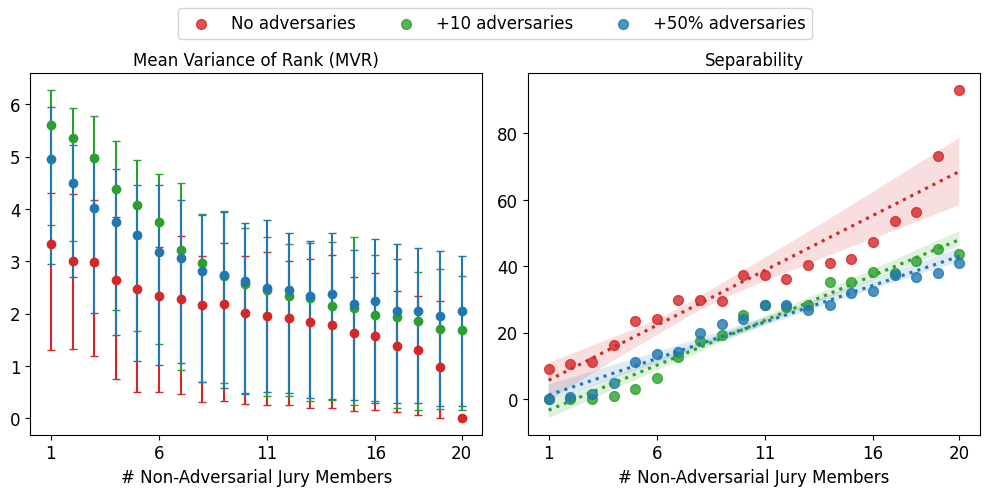

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_jury_ablation(jury_ablation_stats_map, main_stat_name, main_stat, main_stat_upper, main_stat_lower, title1, title2):
    # Create a new figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Collect all unique jury sizes for setting x-ticks
    all_jury_sizes = []

    # Plot the first subplot (Variance of assigned rankings)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        # Append the jury sizes to the list
        all_jury_sizes.extend(jury_ablation_stats.index.astype(int).tolist())
        
        axes[0].errorbar(
            jury_ablation_stats.index.astype(int),
            jury_ablation_stats[main_stat],
            yerr=[
                jury_ablation_stats[main_stat] - jury_ablation_stats[main_stat_lower],
                jury_ablation_stats[main_stat_upper] - jury_ablation_stats[main_stat],
            ],
            fmt='o',  # 'o' for circular markers
            label=label,
            color=color,
            capsize=3,  # Add caps to the error bars
        )

    xticks = sorted(set(all_jury_sizes))
    # Select every 5th tick
    xticks = [tick for i, tick in enumerate(xticks) if i % 5 == 0 or i == len(xticks) - 1]
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticks, fontsize=12)
    axes[0].set_xlabel("# Non-Adversarial Jury Members", fontsize=12)
    axes[0].set_title("Mean Variance of Rank (MVR)", fontsize=12)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].tick_params(axis='both', which='minor', labelsize=12)

    # Plot the second subplot (Separability)
    for (label, color), jury_ablation_stats in jury_ablation_stats_map.items():
        df = pd.DataFrame({
            'Jury Size': jury_ablation_stats.index.astype(int),  # Convert to numerical
            'Separability': jury_ablation_stats['separability.mean']
        })
        
        all_jury_sizes.extend(df['Jury Size'].unique())

        sns.regplot(
            ax=axes[1],
            x='Jury Size', 
            y='Separability', 
            data=df, 
            label=label, 
            color=color, 
            scatter_kws={'s': 50},  # Size of points
            line_kws={'linestyle': ':'}  # Dotted trendline
        )

    axes[1].set_xticks(xticks)
    axes[1].set_xticklabels(xticks, fontsize=12)
    axes[1].set_xlabel("# Non-Adversarial Jury Members", fontsize=12)
    axes[1].set_ylabel("", fontsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='minor', labelsize=12)
    axes[1].set_title("Separability", fontsize=12)

    # Create a single legend for both subplots
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(jury_ablation_stats_map), fontsize=12)

    # Adjust layout to make room for the shared legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig("/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/conversational_response_judging.100_to_200.qwen_32b_reference/jury_ablation_combined.pdf")
    plt.show()


plot_combined_jury_ablation(
    jury_ablation_stats_map={
        ("No adversaries", "tab:red"): jury_ablation_stats,
        ("+10 adversaries", "tab:green"): jury_ablation_stats_with_adversarial_judges,
        ("+50% adversaries", "tab:blue"): jury_ablation_stats_with_adversarial_judges_fixed_percentage,
    },
    main_stat_name="rank σ",
    main_stat="rank_std.mean", 
    main_stat_upper="rank_std.ci.upper", 
    main_stat_lower="rank_std.ci.lower",
    title1="Variance of assigned LLM rankings over simulated jury compositions (n=100)",
    title2="Separability over simulated jury compositions (n=100)"
)
